In [1]:
import numpy as np
import xarray as xr
import os
import glob
from pathlib import Path 
import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
import time
import requests
import s3fs
from os.path import dirname, join
import datetime
import myDate
import netCDF4

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')

In [2]:
main_dir = Path('/home/jpluser/ECCO_GMSL/')
output_dir = Path('/home/jpluser/ECCO_GMSL/Data/GMSL/')
fig_dir = Path('/home/jpluser/ECCO_GMSL/Figures/')

ecco_mean = xr.open_dataset(str(Path('/home/jpluser/ECCO_GMSL/Data')) + '/ECCO_V4r4_mean_SSH_nosicapplied.nc')
ecco_mean_all = xr.open_dataset(str(Path('/home/jpluser/ECCO_GMSL/Data')) + '/ECCO_V4r4_mean_SSH_alllatnosicapplied.nc')

# Compute GMSL from daily ECCO output with simple weighing

### Compute the ocean area, needed to compute GMSL from ECCO

In [48]:
ECCO_grid = xr.open_dataset(str(main_dir) + '/Data/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc')
ECCO_grid

<xarray.Dataset> Size: 121MB
Dimensions:         (Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    latitude_bnds   (latitude, nv) float32 3kB ...
    longitude_bnds  (longitude, nv) float32 6kB ...
    Z_bnds          (Z, nv) float32 400B ...
Dimensions without coordinates: nv
Data variables:
    hFacC           (Z, latitude, longitude) float64 104MB ...
    Depth           (latitude, longitude) float64 2MB ...
    area            (latitude, longitude) float64 2MB ...
    drF             (Z) float32 200B ...
    maskC           (Z, latitude, longitude) bool 13MB ...
Attributes: (12/57)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the 0.5 deg...
    uuid:                            b4795c62-86e5-11eb-9c5f-f8f21e2ee3e0

In [49]:
# # mask land points
# ECCO_ocean_area_all = ECCO_grid.area*ECCO_grid.maskC[0,:]
# ECCO_ocean_area_all=ECCO_ocean_area_all.drop('Z')
# ECCO_ocean_area_all

In [50]:
# # mask high latitudes
# ECCO_ocean_area=ECCO_ocean_area_all.sel(latitude=slice(-66,66))
# ECCO_ocean_area

In [51]:
# ECCO_total_ocean_area_all = ECCO_ocean_area_all.sum(skipna=True).values
# ECCO_total_ocean_area_all

In [52]:
# ECCO_total_ocean_area_zonal_all = ECCO_ocean_area_all.sum(dim=['longitude'],skipna=True).values
# ECCO_total_ocean_area_zonal_all.shape

In [53]:
# ECCO_total_ocean_area = ECCO_ocean_area.sum(skipna=True).values
# ECCO_total_ocean_area

In [54]:
# ECCO_total_ocean_area_zonal = ECCO_ocean_area.sum(dim=['longitude'],skipna=True).values
# ECCO_total_ocean_area_zonal.shape

### Get the list of ECCO daily data in the cloud

In [55]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds

creds = store_aws_keys()
print(creds)

In [56]:
ShortName = "ECCO_L4_SSH_05DEG_DAILY_V4R4B"
# Ask PODAAC for the collection id
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)
ummc = response.json()['items']
# ummc
# used to work, doesn't work anymore...
# ummc = response.json()['items'][0]
# ccid = ummc['meta']['concept-id']
# print(f'collection id: {ccid}')

In [57]:
s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

In [58]:
# make a S3 'filesystem' object
fs = s3fs.S3FileSystem(anon=False,
                      key=creds['AccessKeyId'],
                      secret=creds['SecretAccessKey'],
                      token=creds['SessionToken'])

### Read ECCO data from the cloud

In [59]:
ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*.nc'))
# ECCO_SSH_files

In [60]:
#we only start on 09-23-1992, doy=266
ECCO_SSH_files=ECCO_SSH_files[266:]
# ECCO_SSH_files

In [61]:
#Load all of the files from AWS S3 using 'direct connection' and combine into a single xarray DataSet object
paths=[fs.open(f) for f in ECCO_SSH_files] 
ECCO_DS_daily_all = xr.open_mfdataset(
    paths=paths,
    combine='by_coords',
    # concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}  
)
ECCO_DS_daily_all.close()
ECCO_DS_daily_all

<xarray.Dataset> Size: 29GB
Dimensions:         (time: 9231, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 74kB 1992-09-23T12:00:00 ... 2017-1...
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] 148kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 10GB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 10GB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 10GB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ou Wang and Ian Fenty
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-09-24T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-09-23T00:00:00
    title:                        ECCO Sea Surface Height - Daily Mean 0.5 De...
    uuid:                         44a9c25e-9a8a-414c-85e0-ebe688de113d

In [62]:
ECCO_SSH_all = ECCO_DS_daily_all.SSH-ecco_mean_all.mean_ssh

In [63]:
ECCO_SSH_all=ECCO_SSH_all.resample(time="10D",loffset=datetime.timedelta(days=4)).mean()

### Calculate the True daily GMSL from ECCO

In [64]:
# #!!!!!PROBLEM WITH SEA ICE NOT MASKED IN AREA COMPUTATION WITH THIS METHOD !!!!
# # first call sets up the calculation in dask
# # ... \sum_i [SSH_i x grid cell area_i] / total grid cell area
# ECCO_global_mean_sea_level_all = (ECCO_SSH_all * ECCO_ocean_area_all).sum(dim=['latitude','longitude'],skipna=True)/ECCO_total_ocean_area_all

# # second call actually computes it
# ECCO_global_mean_sea_level_all = ECCO_global_mean_sea_level_all.compute()

In [65]:
[LO,LA]=np.meshgrid(ECCO_SSH_all.longitude,ECCO_SSH_all.latitude)
weights = np.cos(np.deg2rad(LA))
weights=np.tile(weights, [ECCO_SSH_all.shape[0], 1, 1])
weights[np.where(~np.isfinite(ECCO_SSH_all))]=np.nan
ECCO_global_mean_sea_level_all_tmp=np.nansum(ECCO_SSH_all*weights,axis=(1,2))/np.nansum(weights,axis=(1,2))

### Save to Disk

In [66]:
ECCO_global_mean_sea_level_all = xr.Dataset({"gmsl_ecco": (("time"), ECCO_global_mean_sea_level_all_tmp)},
            coords={"time": ECCO_SSH_all.time})
ECCO_global_mean_sea_level_all['gmsl_ecco'].attrs['unit'] = 'm'
fname = output_dir / ('GMSL_ECCO_dailyfiles_19922017_alllat_nosicapplied.nc')
ECCO_global_mean_sea_level_all.to_netcdf(fname)
ECCO_global_mean_sea_level_all
ECCO_global_mean_sea_level_all_tmp=[]

### +/- 66

In [67]:
ECCO_DS_daily=ECCO_DS_daily_all.sel(latitude=slice(-66,66))
ECCO_DS_daily

<xarray.Dataset> Size: 21GB
Dimensions:         (time: 9231, latitude: 264, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 74kB 1992-09-23T12:00:00 ... 2017-1...
  * latitude        (latitude) float32 1kB -65.75 -65.25 -64.75 ... 65.25 65.75
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] 148kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 2kB dask.array<chunksize=(264, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ou Wang and Ian Fenty
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-09-24T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-09-23T00:00:00
    title:                        ECCO Sea Surface Height - Daily Mean 0.5 De...
    uuid:                         44a9c25e-9a8a-414c-85e0-ebe688de113d

In [68]:
ECCO_SSH = ECCO_DS_daily.SSH-ecco_mean.mean_ssh
ECCO_SSH

<xarray.DataArray (time: 9231, latitude: 264, longitude: 720)> Size: 7GB
dask.array<sub, shape=(9231, 264, 720), dtype=float32, chunksize=(1, 264, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 74kB 1992-09-23T12:00:00 ... 2017-12-31T...
  * latitude   (latitude) float32 1kB -65.75 -65.25 -64.75 ... 64.75 65.25 65.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8

In [69]:
ECCO_SSH=ECCO_SSH.resample(time="10D",loffset=datetime.timedelta(days=4)).mean()
ECCO_SSH

<xarray.DataArray (time: 924, latitude: 264, longitude: 720)> Size: 703MB
dask.array<transpose, shape=(924, 264, 720), dtype=float32, chunksize=(1, 264, 720), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 1kB -65.75 -65.25 -64.75 ... 64.75 65.25 65.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * time       (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04

### Calculate the True daily GMSL from ECCO

In [70]:
# #!!!!!PROBLEM WITH SEA ICE NOT MASKED IN AREA COMPUTATION WITH THIS METHOD !!!!
# # first call sets up the calculation in dask
# # ... \sum_i [SSH_i x grid cell area_i] / total grid cell area
# ECCO_global_mean_sea_level = (ECCO_SSH * ECCO_ocean_area).sum(dim=['latitude','longitude'],skipna=True)/ECCO_total_ocean_area

# # second call actually computes it
# ECCO_global_mean_sea_level = ECCO_global_mean_sea_level.compute()

In [71]:
[LO,LA]=np.meshgrid(ECCO_SSH.longitude,ECCO_SSH.latitude)
weights = np.cos(np.deg2rad(LA))
weights=np.tile(weights, [ECCO_SSH.shape[0], 1, 1])
weights[np.where(~np.isfinite(ECCO_SSH))]=np.nan
ECCO_global_mean_sea_level_tmp=np.nansum(ECCO_SSH*weights,axis=(1,2))/np.nansum(weights,axis=(1,2))

### Save to Disk

In [72]:
ECCO_global_mean_sea_level = xr.Dataset({"gmsl_ecco": (("time"), ECCO_global_mean_sea_level_tmp)},
            coords={"time": ECCO_SSH.time})
ECCO_global_mean_sea_level['gmsl_ecco'].attrs['unit'] = 'm'
fname = output_dir / ('GMSL_ECCO_dailyfiles_19922017_nosicapplied.nc')
ECCO_global_mean_sea_level.to_netcdf(fname)
ECCO_global_mean_sea_level
ECCO_global_mean_sea_level_tmp=[]

### Plots ECCO GMSL

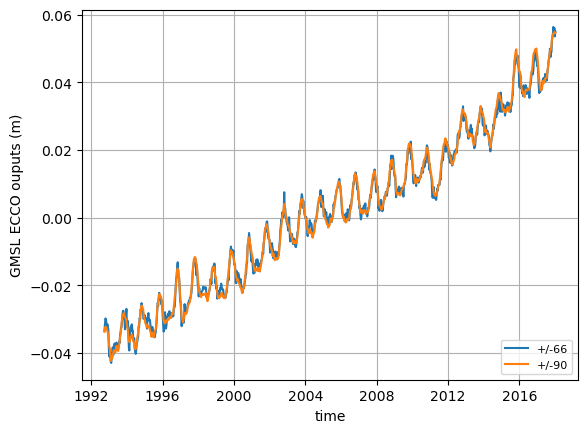

In [73]:
fig=plt.figure()
(ECCO_global_mean_sea_level.gmsl_ecco).plot(label='+/-66');
(ECCO_global_mean_sea_level_all.gmsl_ecco).plot(label='+/-90');
plt.grid()
plt.ylabel('GMSL ECCO ouputs (m)')
plt.legend(ncol=1, loc='lower right',fontsize=8)
# plt.savefig(fig_dir / 'GMSL_ecco_output_66_alllat_nosicapplied.png',dpi=200,transparent=False,facecolor='white')

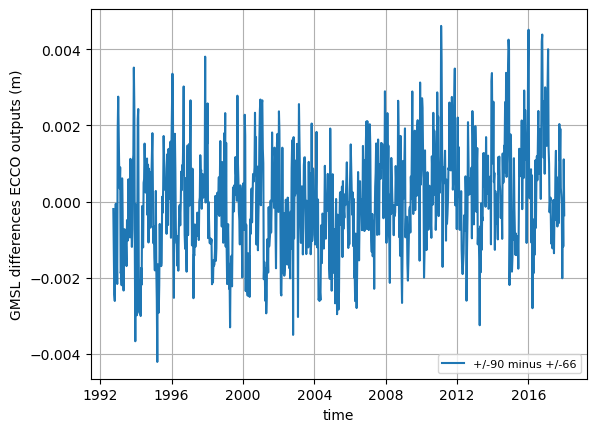

In [74]:
fig=plt.figure()
(ECCO_global_mean_sea_level_all.gmsl_ecco-ECCO_global_mean_sea_level.gmsl_ecco).plot(label='+/-90 minus +/-66')
plt.grid()
plt.title('')
plt.ylabel('GMSL differences ECCO outputs (m)')
plt.legend(ncol=2, loc='lower right',fontsize=8)
# plt.savefig(fig_dir / 'GMSL_ecco_output_66minusalllat_nosicapplied2.png',dpi=200,transparent=False,facecolor='white')

### Zonal plots

In [75]:
[LO,LA]=np.meshgrid(ECCO_SSH_all.longitude,ECCO_SSH_all.latitude)
weights_all = np.cos(np.deg2rad(LA))
weights_all=np.tile(weights_all, [ECCO_SSH_all.shape[0], 1, 1])
weights_all[np.where(~np.isfinite(ECCO_SSH_all))]=np.nan

In [76]:
weights_all.shape

(924, 360, 720)

In [77]:
[LO,LA]=np.meshgrid(ECCO_SSH.longitude,ECCO_SSH.latitude)
weights = np.cos(np.deg2rad(LA))
weights=np.tile(weights, [ECCO_SSH.shape[0], 1, 1])
weights[np.where(~np.isfinite(ECCO_SSH))]=np.nan

In [78]:
weights.shape

(924, 264, 720)

In [79]:
ECCO_global_mean_sea_level_zonal_all = np.nansum(ECCO_SSH_all * weights_all,axis=2)/np.nansum(weights_all,axis=2)
ECCO_global_mean_sea_level_zonal_all=xr.DataArray(ECCO_global_mean_sea_level_zonal_all,coords=[('time', ECCO_SSH_all['time'].data), ('latitude',ECCO_SSH_all['latitude'].data)])
ECCO_global_mean_sea_level_zonal_all

<xarray.DataArray (time: 924, latitude: 360)> Size: 1MB
array([[        nan,         nan,         nan, ..., -0.03412549,
        -0.03277249, -0.03211491],
       [        nan,         nan,         nan, ..., -0.02149684,
        -0.02018972, -0.01943321],
       [        nan,         nan,         nan, ..., -0.09551443,
        -0.09657043, -0.09778699],
       ...,
       [        nan,         nan,         nan, ...,  0.05233834,
         0.05121552,  0.05049295],
       [        nan,         nan,         nan, ...,  0.07742751,
         0.07659134,  0.07580395],
       [        nan,         nan,         nan, ...,  0.02864527,
         0.03131688,  0.0337014 ]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
  * latitude  (latitude) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75

In [80]:
ECCO_global_mean_sea_level_zonal = np.nansum(ECCO_SSH * weights,axis=2)/np.nansum(weights,axis=2)
ECCO_global_mean_sea_level_zonal=xr.DataArray(ECCO_global_mean_sea_level_zonal,coords=[('time', ECCO_SSH['time'].data), ('latitude',ECCO_SSH['latitude'].data)])
ECCO_global_mean_sea_level_zonal

<xarray.DataArray (time: 924, latitude: 264)> Size: 976kB
array([[-0.00874824, -0.00774961, -0.00675028, ..., -0.05365226,
        -0.05475977, -0.0515228 ],
       [-0.03428148, -0.03337971, -0.03308047, ..., -0.0380056 ,
        -0.03600314, -0.02611234],
       [-0.03079682, -0.03146796, -0.0321849 , ..., -0.04883447,
        -0.05474864, -0.05992839],
       ...,
       [ 0.06136455,  0.06166234,  0.0612837 , ..., -0.00280478,
         0.00182492,  0.01815183],
       [ 0.06727656,  0.06605919,  0.06441129, ...,  0.07094148,
         0.07688764,  0.08102608],
       [ 0.07270465,  0.07178693,  0.06948471, ...,  0.0571642 ,
         0.04832691,  0.03599409]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
  * latitude  (latitude) float32 1kB -65.75 -65.25 -64.75 ... 64.75 65.25 65.75

Text(0, 0.5, 'zonal GMSL (m)')

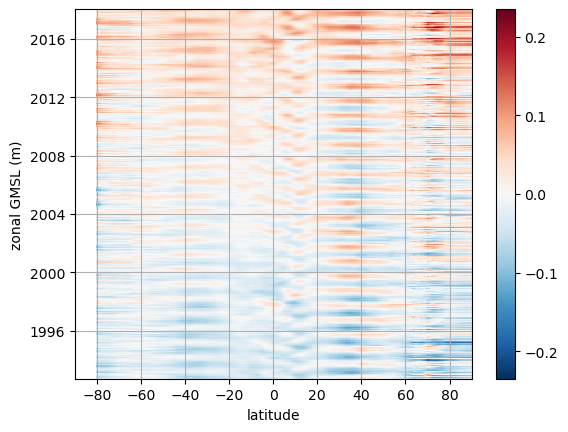

In [81]:
(ECCO_global_mean_sea_level_zonal_all).plot();
plt.grid()
plt.ylabel('zonal GMSL (m)')

Text(0, 0.5, 'zonal GMSL (m)')

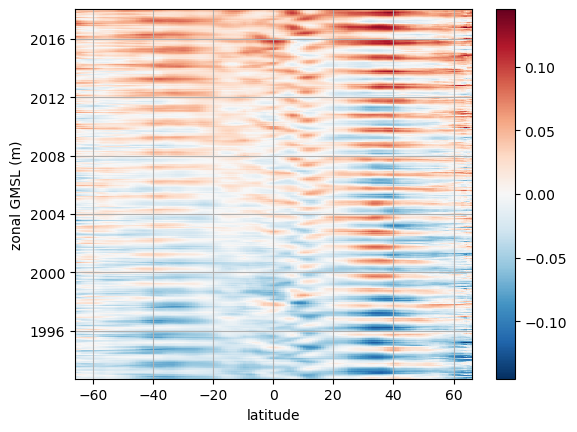

In [82]:
(ECCO_global_mean_sea_level_zonal).plot();
plt.grid()
plt.ylabel('zonal GMSL (m)')

In [83]:
ECCO_global_slope_mean_sea_level_zonal=ECCO_global_mean_sea_level_zonal.polyfit(dim='time', deg=1, skipna=True, rcond=None, w=None, full=False, cov=False)
ECCO_global_slope_mean_sea_level_zonal

<xarray.Dataset> Size: 5kB
Dimensions:               (latitude: 264, degree: 2)
Coordinates:
  * latitude              (latitude) float32 1kB -65.75 -65.25 ... 65.25 65.75
  * degree                (degree) int64 16B 1 0
Data variables:
    polyfit_coefficients  (degree, latitude) float64 4kB 7.305e-20 ... -0.1041

Text(0.5, 0, 'Latitude')

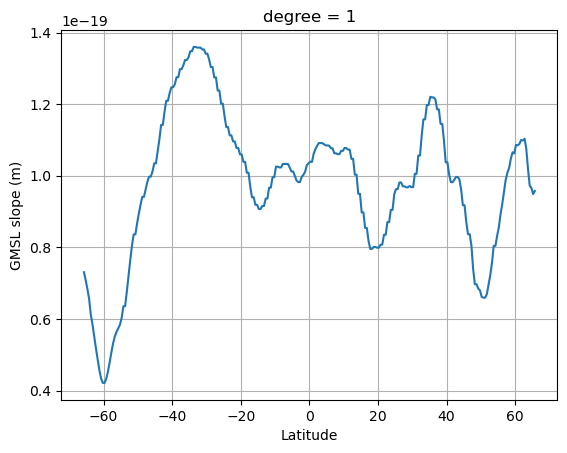

In [84]:
(ECCO_global_slope_mean_sea_level_zonal.polyfit_coefficients[0,:]).plot();
plt.grid()
plt.ylabel('GMSL slope (m)')
plt.xlabel('Latitude')
# fname = output_dir / ('temp.nc')
# ECCO_global_mean_sea_level_zonal.to_netcdf(fname)

### Variance ECCO GMSL

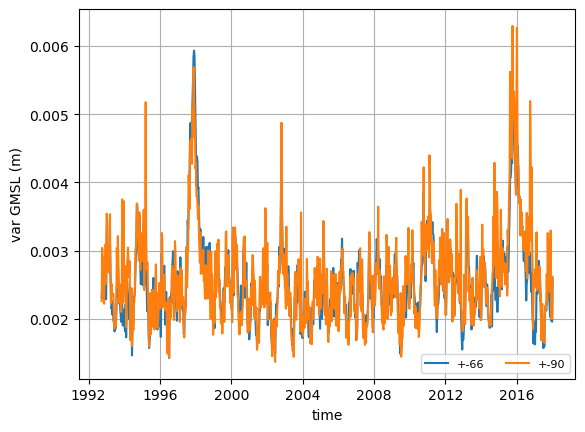

In [85]:
(ECCO_SSH.var(dim=('latitude','longitude'),skipna=True)).plot(label='+-66');
(ECCO_SSH_all.var(dim=('latitude','longitude'),skipna=True)).plot(label='+-90');
plt.grid()
plt.ylabel('var GMSL (m)')
plt.legend(ncol=2, loc='lower right',fontsize=8)

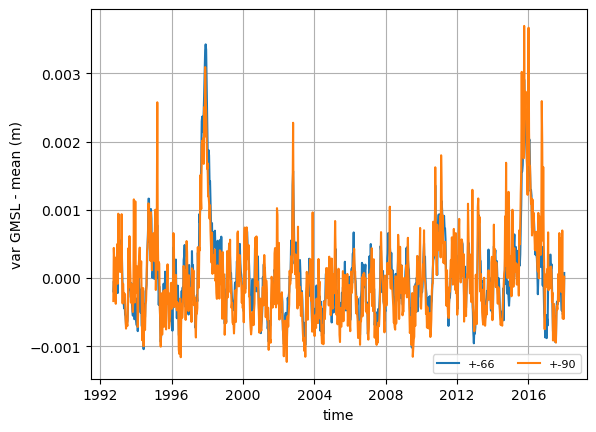

In [86]:
((ECCO_SSH.var(dim=('latitude','longitude'),skipna=True))-(ECCO_SSH.var(dim=('latitude','longitude'),skipna=True)).mean()).plot(label='+-66');
((ECCO_SSH_all.var(dim=('latitude','longitude'),skipna=True))-(ECCO_SSH_all.var(dim=('latitude','longitude'),skipna=True)).mean()).plot(label='+-90');
plt.grid()
plt.ylabel('var GMSL - mean (m)')
plt.legend(ncol=2, loc='lower right',fontsize=8)